<a href="https://colab.research.google.com/github/etgins/Computer-Vision-Alg-App-HW/blob/main/ee046746_hw3_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Homework 3 - Segmentation***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.ndimage
from scipy import io
import math
%matplotlib inline
import time
import os
import PIL
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

***Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation***

In this part you are going to compare classic methods for segmentation to deep learning-based methods. You are also going to see the effect of the
background on classification.
1. Load the images in the ./data/frogs and ./data/horses folders and display them.
2. Pick 1 classic method for segmentation and 1 deep learning-based method and segment the given images. Display the results.
Briefly summarize each method you picked and discuss the advantages and disadvantages of each method. In your answer, relate to the
results you received in this section.
Note: the classic method must not use any neural network.
3. Pick 3 images (download from the internet or take them yourself) that satisfy the following, and display them:
One image of a living being (human, animal,...).
One image of commonly-used object (car, chair, smartphone, glasses,...).
One image of not-so-commonly-used object (fire extinguisher, satellite,... BE CREATIVE).
4. Apply each method (one classic and one deep learning-based) on the 3 images. Display the results.
Which method performed better on each image? Describe your thoughts on why one method is better than the other.
5. As you probably have noticed, segmentation can be rough around the edges, i.e., the mask is not perfect and may be noisy around the edges.
What can be done to fix or at least alleviate this problem? Your suggestions can be in pre-processing, inside the segmentation algorithm or in
post-processing.
6. Load a pre-trained classifier (which was trained on ImageNet) from: https://pytorch.org/vision/stable/models.html#classification
(https://pytorch.org/vision/stable/models.html#classification). In the previous assignment you used VGG16, but you can choose a different one
for this assignment.

7. Pick an image of an animal in its natural habitat (e.g., cow on grass fields, zebra in the safari, ...). Display the image you chose and feed-
forward it to the pre-trained network. What is the network's prediction? To convert from class index to label, use the supplied

./data/imagenet1000_clsidx_to_labels.txt file. You can also use the supplied ./data/cow.jpg or ./data/sheep.jpg .
8. Segement the animal using one of the methods (classic or deep) and display the result.
9. Put the the animal in a different habitat, i.e., use the mask to place the animal on a different background. You can choose any background you
want (which is not the animal's natural habitat). For example, put the cow on a beach ( ./data/beach.jpg for example) or the elaphant/sheep
in a room ( ./data/room.jpg for example). Display the result.
You should submit the final image in the output folder, in addition to putting in your report.
10. Feed forward the the new image (e.g. the sheep in the room) to the pre-trained network. Was the prediction different than Q7? If so, discuss the
reasons for that to happen.

In [ ]:
DATA_PATH = './data/'
MY_DATA_PATH = './my_data/'
OUTPUT_PATH = './output/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

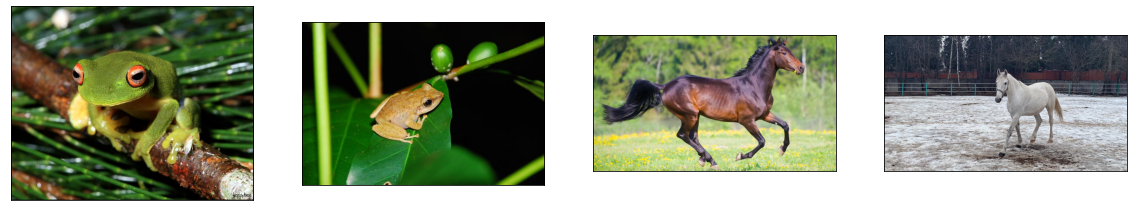

In [ ]:
## 1. Load and display the images

frog_1 = cv2.imread(DATA_PATH+'frogs/frog1.jpg')
frog_2 = cv2.imread(DATA_PATH+'frogs/frog2.jpg')
horse_1 = cv2.imread(DATA_PATH+'horses/horse1.png')
horse_2 = cv2.imread(DATA_PATH+'horses/horse2.jpg')

images = [frog_1,frog_2,horse_1,horse_2]

fig, axes = plt.subplots(1, len(images), figsize=(20,10))
for idx, image in enumerate(images):
    axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))    
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [ ]:
## 2a. Deep Learning-based segmentation

# download and load the pre-trained model
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
# put in inference mode
model.eval();
# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [ ]:
# Deep Learning-based segmentation
def deepSeg(filename,title,model,plotFlag=True):
  # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  input_image = Image.open(filename)

  # define the pre-processing steps
  # image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # perform pre-processing
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

  # send to device
  model = model.to(device)
  input_batch = input_batch.to(device)
  # forward pass
  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  mask = torch.zeros_like(output_predictions).float().to(device)
  mask[output_predictions != 0] = 1
  masked_img = input_image * mask.unsqueeze(2).byte().cpu().numpy()
  masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
  # plot
  if plotFlag:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_title(title)  
    ax.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))  
    ax.set_axis_off()
  return masked_img, mask



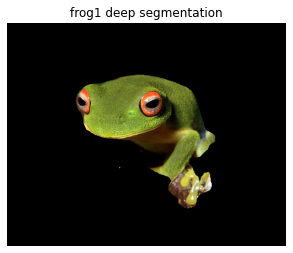

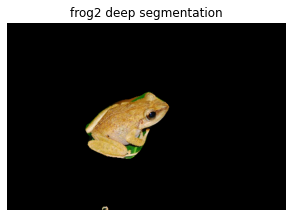

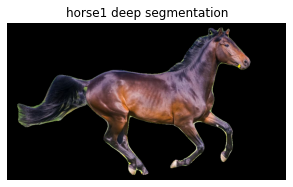

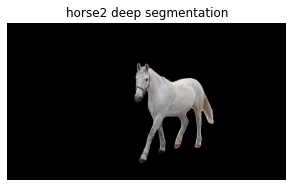

In [ ]:
_,_ = deepSeg(DATA_PATH+'frogs/frog1.jpg','frog1 deep segmentation',model)
_,_ = deepSeg(DATA_PATH+'frogs/frog2.jpg','frog2 deep segmentation',model)
_,_ = deepSeg(DATA_PATH+'horses/horse1.png','horse1 deep segmentation',model)
_,_ = deepSeg(DATA_PATH+'horses/horse2.jpg','horse2 deep segmentation',model)


In [ ]:
# green = np.uint8([[[0,255,0 ]]])
# hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
# print( hsv_green )

In [ ]:
# Func required for part 2 - perform img preperation (based on tutorial 1)
def img_prep(img):
  # img = cv2.imread(img) 
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
  lower_green = np.array([40, 100, 100])
  upper_green = np.array([80, 255, 255])
  
  threshold_green_img = cv2.inRange(hsv, lower_green, upper_green)
  threshold_green_img = cv2.cvtColor(threshold_green_img, cv2.COLOR_GRAY2BGR)
  threshold_green_img = cv2.bitwise_not(threshold_green_img)
  img_converted = cv2.bitwise_and(img, threshold_green_img)
  # fig = plt.figure(figsize=(5,5))
  # ax = fig.add_subplot(111)
  # # ax.set_title(title)  
  # # ax.imshow(cv2.cvtColor(img_converted, cv2.COLOR_BGR2RGB)) 
  # ax.imshow(img_converted) 
  # ax.set_axis_off()
  return img_converted
# img_prep('/content/output/man_frames/0003.jpg')

In [ ]:
## 2b. Classic segmentation
def classicSeg(imgPath,imgRect,numIter,title,plotFlag=True,greenPrep=False):
  img = cv2.imread(imgPath)
  if greenPrep:
    img=img_prep(img)
  mask = np.zeros(img.shape[:2],np.uint8)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)  
  cv2.grabCut(img,mask,imgRect,bgdModel,fgdModel,numIter,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  masked_img = img*mask2[:,:,np.newaxis]  
  # plot
  if plotFlag:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_title(title)  
    ax.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))  
    ax.set_axis_off()
  return masked_img, mask2


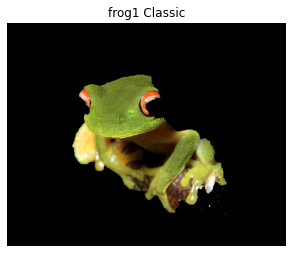

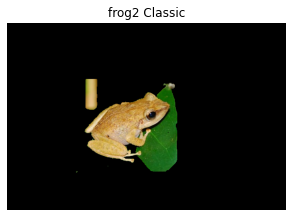

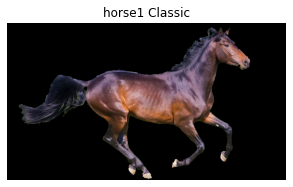

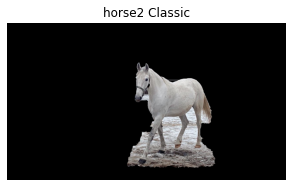

In [ ]:
# all rect positions using paint 
frog1_rect = (85,85,320,270)
_,_ =classicSeg(DATA_PATH+'frogs/frog1.jpg',frog1_rect,2,'frog1 Classic')
frog2_rect = (135,120,225,200)
_,_ =classicSeg(DATA_PATH+'frogs/frog2.jpg',frog2_rect,5,'frog2 Classic')
horse1_rect = (10,10,900,570)
_,_ =classicSeg(DATA_PATH+'horses/horse1.png',horse1_rect,8,'horse1 Classic')
horse2_rect = (585,185,430,520)
_,_ =classicSeg(DATA_PATH+'horses/horse2.jpg',horse2_rect,8,'horse2 Classic')


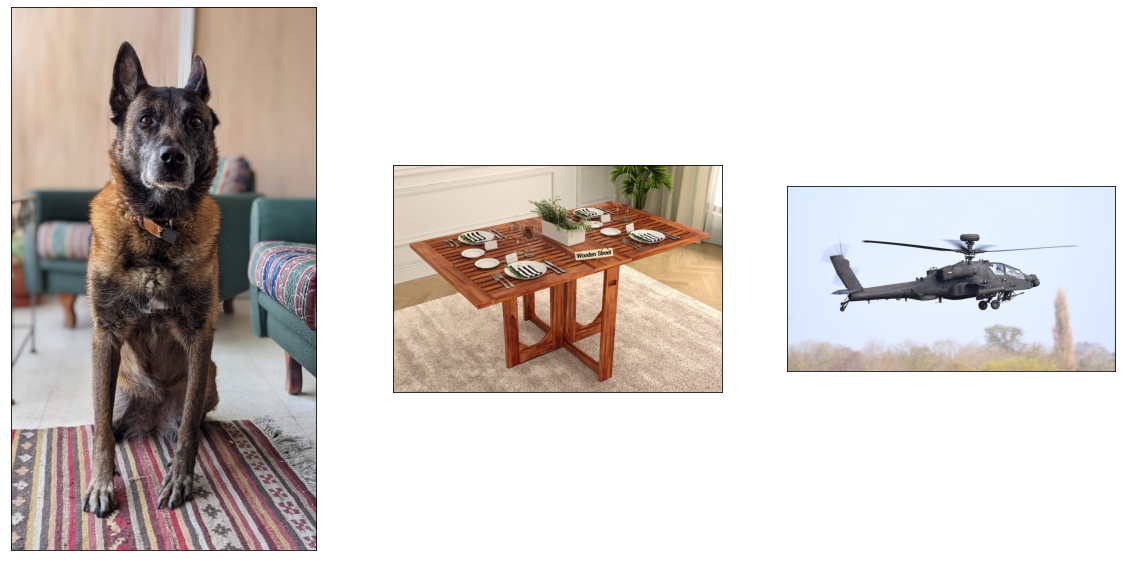

In [ ]:
## 3. Display 3 new images

dog = cv2.imread(MY_DATA_PATH+'dog.jpeg')
table = cv2.imread(MY_DATA_PATH+'table2.jpg')
heli = cv2.imread(MY_DATA_PATH+'helicopter.jpg')


my_images = [dog,table,heli]

fig, axes = plt.subplots(1, len(my_images), figsize=(20,10))
for idx, img in enumerate(my_images):  
    axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

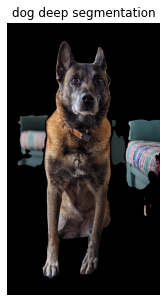

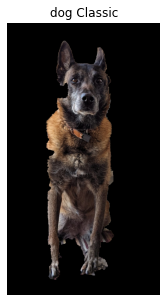

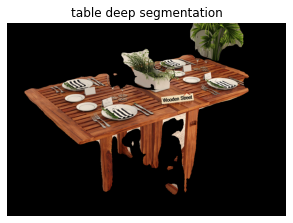

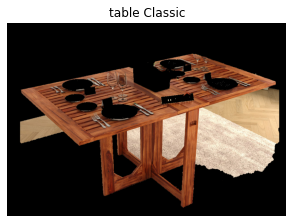

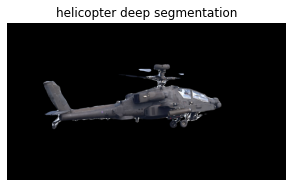

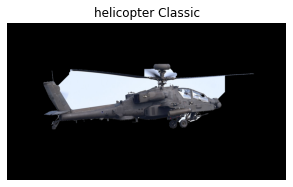

In [ ]:
## 4. Apply each method to the new images
dog = cv2.imread(MY_DATA_PATH + 'dog.jpeg')
table = cv2.imread(MY_DATA_PATH + 'table2.jpg')
heli = cv2.imread(MY_DATA_PATH + 'helicopter.jpg')
# dog
dog_rect = (200,85,430,1430)
_,_ =deepSeg(MY_DATA_PATH + 'dog.jpeg','dog deep segmentation',model)
_,_ =classicSeg(MY_DATA_PATH + 'dog.jpeg',dog_rect,2,'dog Classic')

# table
# table_rect = (215,440,1330,610)
table_rect = (50,100,990,610)
_,_ =deepSeg(MY_DATA_PATH + 'table2.jpg','table deep segmentation',model)
_,_ =classicSeg(MY_DATA_PATH + 'table2.jpg',table_rect,10,'table Classic')

# helicopter
heli_rect = (200,225,1630,580)
_,_ =deepSeg(MY_DATA_PATH + 'helicopter.jpg','helicopter deep segmentation',model)
_,_ =classicSeg(MY_DATA_PATH + 'helicopter.jpg',heli_rect,10,'helicopter Classic')

for cow in grass VGG 16 predicted: ox


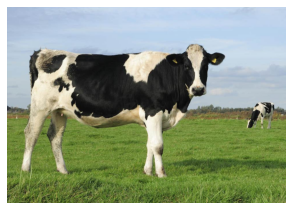

In [ ]:
## 6. Load Pre-trained classifier
# all using our code from last assignment:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_pretrained = torchvision.models.vgg16(pretrained=True, progress=True).to(device)

# preproccess
def fit_to_vgg16(im,size,device=torch.device("cpu")):

    transform = transforms.Compose([
                    transforms.Resize((size,size)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])    
    return ((transform(im)).unsqueeze(0).to(device))

# import labels of imagnet
import json
with open(MY_DATA_PATH + 'imagenet_class_index.json', 'r') as f:
    labels = json.load(f)

labels = {int(key): value[1] for key, value in labels.items()}

# function assuming vgg 16 in eval mode, and given image fits to vgg 16. print vgg 16 prediction for given image 
def vgg16_predict(im,im_title):
  with torch.no_grad():
    im_vgg_output = vgg16_pretrained(im)
    _, im_vgg_pred = torch.max(im_vgg_output.data, 1)
    idx = im_vgg_pred.item()
    print('for '+ im_title + ' VGG 16 predicted: {0}'.format(labels[idx] ))
  return

## 7. feed-forward an animal image through the classifier
cow_toVGG = fit_to_vgg16(Image.open(DATA_PATH + "cow.jpg"), 224,device)
# verify eval mode
vgg16_pretrained.eval()
# feed fwd & predict
vgg16_predict(cow_toVGG,'cow in grass')

# plot cow img
cow = cv2.imread(DATA_PATH + 'cow.jpg')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(cow, cv2.COLOR_BGR2RGB))  
ax.set_axis_off()

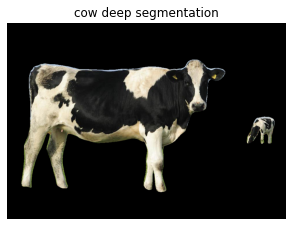

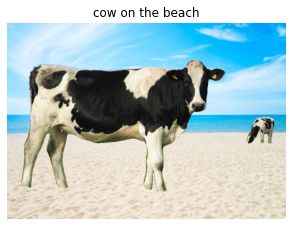

In [ ]:
## 8. Segment the animal image
masked_cow, cow_mask = deepSeg(DATA_PATH + 'cow.jpg','cow deep segmentation',model)
## 9. Place the animal in a different background
neg_mask = torch.zeros(masked_cow.shape[:2])
neg_mask[cow_mask!=1]=1
beach = Image.open(DATA_PATH + 'beach.jpg')
resize = transforms.Resize(neg_mask.shape)
beach = resize(beach)
masked_beach = beach*neg_mask.unsqueeze(2).byte().cpu().numpy()
masked_cow = cv2.cvtColor(masked_cow, cv2.COLOR_BGR2RGB)
cow_on_the_beach = masked_cow + masked_beach
# plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_title('cow on the beach')  
ax.imshow(cow_on_the_beach)  
ax.set_axis_off()


In [ ]:
# print(masked_beach.shape)

In [ ]:
# OUTPUT_PATH = '/content/output/'
cow_on_the_beach_Im = Image.fromarray(cow_on_the_beach)
cow_on_the_beach_Im.save(OUTPUT_PATH + "my_cow_on_the_beach.jpg")

In [ ]:
## 10. feed-forward the created image through the classifier
cow_on_the_beach_toVGG = fit_to_vgg16(Image.open(OUTPUT_PATH + 'my_cow_on_the_beach.jpg'), 224,device)
# verify eval mode
vgg16_pretrained.eval()
# feed fwd & predict
vgg16_predict(cow_on_the_beach_toVGG,'cow on a beach')


for cow on a beach VGG 16 predicted: ox


***Part 2 - Jurrasic Fishbach***

In this part you are going to apply segmentation on a video, and integrate with other elements.

1. Film a short video of yourself (you can use your phone/webcam for that), but without too much camera movement. You, on the other hand, can
move -- walk/move you hands... (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution
(lower than 720p ~ 1280x720 pixles). You can use the function in frame_video_convert.py to help you. Display 2 frames in the report.
2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.
3. Pick one of the objects in the supplied videos ( ./data/dancing_man_model.mp4 , ./data/dinosaur_model.mp4 ,
./data/jet_model.mp4 ), convert it to images and segement it out using one of the methods (classic or deep). Display 2 frames in the report.
You can choose another object from: https://pixabay.com/videos/search/green%20screen/
(https://pixabay.com/videos/search/green%20screen/).
Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you use a simple (e.g. from
tutorial 1)/classic method? Deep method? Combined both? Occam's Razor (https://en.wikipedia.org/wiki/Occam%27s_razor).
4. Put it all together - pick a background (can be a video or static image), put yourself (the segmented-self) and the segemented object on the
background. Stitch it frame-by-frame (don't make the video too long or it will take a lot of time, 10-20 seconds maximum). Display 2 frames of
the result. Convert the frames back to video. You can use the function in frame_video_convert.py to help you.
Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the
new image.
You should submit the final video in the output folder (MANDATORY), and upload it to YouTube (OPTIONAL) as instructed above.
We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.

In [ ]:
## 1. Import the video
# based on given func in frame_video_convert.py
import glob
def video_to_image_seq(vid_path, output_path = OUTPUT_PATH + 'frames/'):
    os.makedirs(output_path, exist_ok=True)
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    im_list = []
    print("converting video to frames...")
    while success:
        fname = str(count).zfill(4)
        # if len(im_list) == 1:
        #   print(output_path + fname + ".jpg")
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
        success, image = vidcap.read()
        # if success:
        im_list.append(output_path + fname + ".jpg")
        # print('Read a new frame: ', success)
        count += 1
    print("total frames: ", count)
    return im_list

In [ ]:
# Func required for part 2 - perform img preperation (based on tutorial 1)
def img_green_removal(img):
  img = cv2.imread(img) 
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
  lower_green = np.array([40, 100, 100])
  upper_green = np.array([80, 255, 255])
  
  threshold_green_img = cv2.inRange(hsv, lower_green, upper_green)
  threshold_green_img = cv2.cvtColor(threshold_green_img, cv2.COLOR_GRAY2BGR)
  threshold_green_img = cv2.bitwise_not(threshold_green_img)
  img_converted = cv2.bitwise_and(img, threshold_green_img)
  # fig = plt.figure(figsize=(5,5))
  # ax = fig.add_subplot(111)
  # # ax.set_title(title)  
  # # ax.imshow(cv2.cvtColor(img_converted, cv2.COLOR_BGR2RGB)) 
  # ax.imshow(img_converted) 
  # ax.set_axis_off()
  return img_converted, threshold_green_img
# img_green_removal('/content/output/man_frames/0003.jpg')

In [ ]:
## 2. Segment the video, frame-by-frame
def segment_all_frames(sorted_frames_list,model,output_path,classic_flag=False,green_flag=False):
  # sorted_frames_list = frames_list.sort()
  # print(type(sorted_frames_list))
  frames_masks=[]
  os.makedirs(output_path, exist_ok=True)
  for idx in range(len(sorted_frames_list)):
    if green_flag:
      masked_img,mask = img_green_removal(sorted_frames_list[idx])
    elif classic_flag:
      man_rect = (280,1,400,550)      
      masked_img,mask = classicSeg(sorted_frames_list[idx],man_rect,5,'',plotFlag=False,greenPrep=True)
    else:
      masked_img,mask = deepSeg(sorted_frames_list[idx],'',model,plotFlag=False)
    frames_masks.append(mask)
    fname = str(idx).zfill(4)
    cv2.imwrite(os.path.join(output_path, fname + ".jpg"), masked_img)  
  return frames_masks



converting video to frames...
total frames:  361


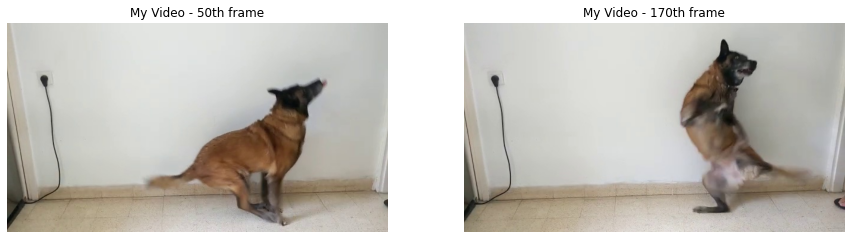

In [ ]:

MY_VIDEO_FRAMES_PATH = OUTPUT_PATH + 'my_frames/'
my_video_frames_list = video_to_image_seq(MY_DATA_PATH + 'my_video.mp4',MY_VIDEO_FRAMES_PATH)
# Display 2 frames from my video:
img_1 =  cv2.imread(MY_VIDEO_FRAMES_PATH + '0050.jpg')
img_2 =  cv2.imread(MY_VIDEO_FRAMES_PATH + '0170.jpg')


fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axes[0].set_title('My Video - 50th frame')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)) 
axes[1].set_title('My Video - 170th frame')
axes[1].axis('off');

In [ ]:
MY_SEG_PATH = OUTPUT_PATH + 'my_video_seg_frames/'
my_video_seg_masks = segment_all_frames(my_video_frames_list,model,MY_SEG_PATH) #tensor
# print(len(my_video_seg_masks))


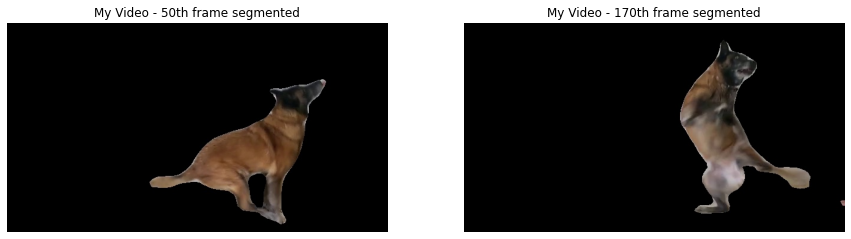

In [ ]:
# Display 2 frames - segmented from my video:
img1 =  cv2.imread(MY_SEG_PATH + '0050.jpg')
img2 =  cv2.imread(MY_SEG_PATH + '0170.jpg')

fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].set_title('My Video - 50th frame segmented')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) 
axes[1].set_title('My Video - 170th frame segmented')
axes[1].axis('off');

converting video to frames...
total frames:  201


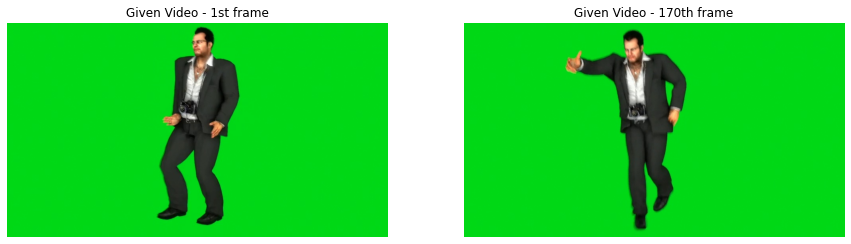

In [ ]:
## 3. convert given video to sequence of images
MAN_PATH = OUTPUT_PATH + 'man_frames/'
man_frames = video_to_image_seq(DATA_PATH + 'dancing_man_model.mp4',MAN_PATH)

# Display 2 frames - from given video:
man1 =  cv2.imread(MAN_PATH + '0000.jpg')
man2 =  cv2.imread(MAN_PATH + '0170.jpg')


fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(cv2.cvtColor(man1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Given Video - 1st frame')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(man2, cv2.COLOR_BGR2RGB)) 
axes[1].set_title('Given Video - 170th frame')
axes[1].axis('off');

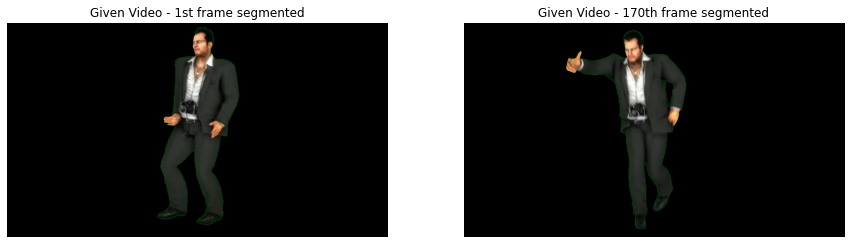

In [ ]:
## Segment the given objects - DEEP
# man_seg_masks = segment_all_frames(man_frames,model,'/content/output/man_seg_frames/')
# print(len(man_seg_masks))


## Segment the given objects - CLASSIC
# man_seg_masks = segment_all_frames(man_frames,model,'/content/output/man_seg_frames/',classic_flag=True)
# print(len(man_seg_masks))

## 3. Segment the given objects - GREEN 
MAN_SEG_PATH = OUTPUT_PATH + 'man_seg_frames/'
man_seg_masks = segment_all_frames(man_frames,model,output_path=MAN_SEG_PATH,green_flag=True)
# print(len(man_seg_masks))

# Display 2 frames - segmented from given video:
man1seg =  cv2.imread(MAN_SEG_PATH + '0000.jpg')
man2seg =  cv2.imread(MAN_SEG_PATH + '0170.jpg')

fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(cv2.cvtColor(man1seg, cv2.COLOR_BGR2RGB))
axes[0].set_title('Given Video - 1st frame segmented')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(man2seg, cv2.COLOR_BGR2RGB))
axes[1].set_title('Given Video - 170th frame segmented')
axes[1].axis('off');

In [ ]:
  # fig = plt.figure(figsize=(5,5))
  # ax = fig.add_subplot(111)
  # # ax.set_title(title)  
  # ax.imshow(cv2.cvtColor(my_video_seg_masks[0].cpu().detach().numpy(), cv2.COLOR_BGR2RGB)) 
  # # ax.imshow(my_video_seg_masks[0].cpu().detach().numpy()) 
  # ax.set_axis_off()
  # print(type(man_seg_masks[0]))

In [ ]:
# !rm -rf "./output/frames/"

In [ ]:
# print((man_seg_masks[0]).shape)
# print(type(my_video_seg_masks[0]))
# t = my_video_seg_masks[0].cpu().detach().numpy()
# print(t.min())

In [ ]:
BG_PIC_PATH = DATA_PATH + 'room.jpg'
# OUTPUT_PATH = '/content/output/'
FINAL_FRAMES_PATH = OUTPUT_PATH + "final_frames/"
os.makedirs(FINAL_FRAMES_PATH, exist_ok=True)
FINAL_VIDEO_PATH = OUTPUT_PATH + "my_final_video.mp4"

In [ ]:
# tp = cv2.imread(BG_PIC_PATH)
# print(tp.shape)

In [ ]:
## 4. Put it all together

# RESIZE TRAMSFORM OF FINAL IMG:
bg_image = cv2.imread(BG_PIC_PATH)
bg_torch = torch.zeros(bg_image.shape[:2])
final_resize = transforms.Resize(bg_torch.shape)

# print(bg_image.shape)
frames_len = min(len(my_video_frames_list),len(man_frames))
for idx in range((frames_len)):
# for idx in range(1):
  # open & resize each frame to BG frame
  fname = str(idx).zfill(4)
  my_frame = Image.open(os.path.join(MY_SEG_PATH, fname + ".jpg"))
  # my_frame_resized = cv2.cvtColor(np.array(final_resize(my_frame)), cv2.COLOR_BGR2RGB)
  my_frame_resized=np.array(final_resize(my_frame))
  given_frame =  Image.open(os.path.join(MAN_SEG_PATH, fname + ".jpg"))
  given_frame_resized = np.array(final_resize(given_frame))
  
  # REMOVE MY FRAME FROM BG
  bg = Image.open(BG_PIC_PATH)
  my_mask = my_video_seg_masks[idx]
  neg_my_mask = torch.zeros(my_mask.shape[:2])
  neg_my_mask[my_mask!=1]=1
  resize = transforms.Resize(neg_my_mask.shape)
  bg_resized = resize(bg)
  neg_my_mask = neg_my_mask.unsqueeze(2).byte().cpu().numpy()
  bg_without_my_pic = (bg_resized*neg_my_mask)
  bg_without_my_pic = Image.fromarray(bg_without_my_pic)
  bg_without_my_pic = final_resize(bg_without_my_pic)
  
  # remove man frame from BG 
  neg_man_mask = (255-man_seg_masks[idx])
  neg_man_mask = Image.fromarray(neg_man_mask*255)
  neg_man_mask = final_resize(neg_man_mask)
  neg_man_mask = np.array(neg_man_mask)
  bg_without_both_frames = neg_man_mask*bg_without_my_pic

  # final_frame = given_frame_resized + my_frame_resized + bg_without_both_frames
  final_frame = given_frame_resized + neg_man_mask*my_frame_resized + bg_without_both_frames  
  final_frame=cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB)
  cv2.imwrite(os.path.join(FINAL_FRAMES_PATH, fname + ".jpg"), final_frame)  # save frame as JPEG file
  
  # my_video_seg_masks[0].cpu().detach().numpy()
  # remove from BG current 
  # output_frame = bg_without_my_pic + my_frame_resized
  # print((given_frame_resized).shape)
  # if idx == 0:
  #   fig, axes = plt.subplots(1, 3, figsize=(15,15))
  #   # axes[0].imshow(cv2.cvtColor(bg_without_pic, cv2.COLOR_BGR2RGB))
  #   axes[0].imshow(bg_without_both_frames)  
  #   axes[0].axis('off')
  # #   axes[1].imshow(given_frame_resized)
  #   axes[1].set_title('Given Video frame segmented')
  #   axes[1].axis('off');
  # print(type(my_resize))
  
  



In [ ]:
# given func in frame_video_convert.py
def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in sorted(glob.glob(os.path.join(imgs_path, '*.jpg'))):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)



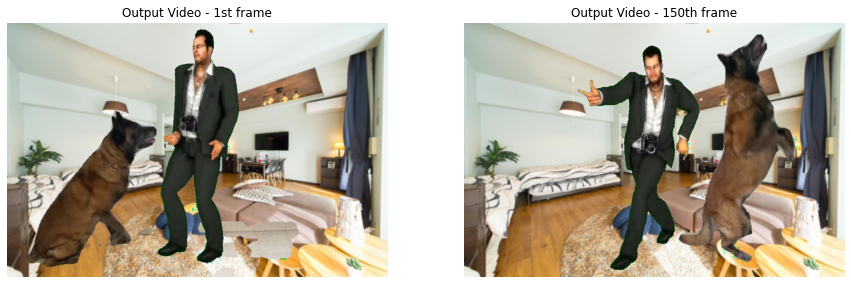

In [ ]:
# Display 2 frames - segmented from output video:
man1seg =  cv2.imread(FINAL_FRAMES_PATH + '0000.jpg')
man2seg =  cv2.imread(FINAL_FRAMES_PATH + '0150.jpg')

fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(cv2.cvtColor(man1seg, cv2.COLOR_BGR2RGB))
axes[0].set_title('Output Video - 1st frame')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(man2seg, cv2.COLOR_BGR2RGB))
axes[1].set_title('Output Video - 150th frame')
axes[1].axis('off');

In [ ]:
image_seq_to_video(FINAL_FRAMES_PATH,FINAL_VIDEO_PATH,fps=33)

(1024, 683)
writing video...
saved video @  /content/output/my_final_video.mp4
